## LORENZ 96 ENCODER DECODER (NO iterative function) ##

Didn't use iterative function for this problem because we are already doing memory intensive work with multiple features (variables)

In [2]:
import numpy as np
# Equation Params
F = 8  # Forcing parameter
N = 25  # Number of variables

np.random.seed(1)
X0 = np.random.randn(N) 

# Time Params
t_end = 100                  # t final (minimum threshold is 100..? model may need some refinement)
t_points = 10000           # points
lyapunov_exponent = 1       # set to 1 to ignore lyapunov

# Split Param
split_ratio = 1/5
validation_split = 1/8

# Scaler Params (don't modify unless you know what you are doing)
feature_range = (0, 1)

# Model Hyperparams (don't need to modify unless want to)
lstm_dim = 384
keep_rate = 0.99
learning_rate = 0.01
epochs = 100
batch_size = 12

# Params for the iterative forecast 
num_iterations = 1

In [3]:
import matplotlib.pyplot as plt
from keras.layers import Input, LSTM, Dense, Concatenate, Lambda, Dot, Activation
from keras.models import Model
from keras.optimizers import Adam
import numpy as np
from scipy.integrate import odeint
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from keras import backend as K

# Define the Lorenz-96 system
def lorenz96(X, t, F):
    N = len(X)
    dXdt = np.zeros(N)
    for i in range(N):
        dXdt[i] = (X[(i + 1) % N] - X[i - 2]) * X[i - 1] - X[i] + F
    return dXdt

# Time span
t = np.linspace(0, t_end, t_points)

# Lyapunov calculations
lyapunov_time = 1 / np.abs(lyapunov_exponent)
t_lyapunov = t / lyapunov_time

# Solve Lorenz-96 equations using odeint
solution = odeint(lorenz96, X0, t_lyapunov, args=(F,))
solution = solution[:, :N]

# Split data into input and ground truth
points_length = int(len(solution) * split_ratio)
input_solution = solution[:points_length]
ground_truth_solution = solution[points_length:]

# Further split data into training, validation, and test sets
validation_length = int(len(input_solution) * validation_split)
X_train = input_solution[:points_length - validation_length]
X_val = input_solution[points_length - validation_length:points_length]
X_test = ground_truth_solution

time_train = t[:points_length - validation_length]
time_val = t[points_length - validation_length:points_length]
time_test = t[points_length:]

# Scale input data
scaler = MinMaxScaler(feature_range=feature_range)
X_train_normalized = scaler.fit_transform(X_train)
X_val_normalized = scaler.transform(X_val)
X_test_normalized = scaler.transform(X_test)

# Reshape input data for LSTM
X_train_normalized = X_train_normalized.reshape(-1, 1, N)
X_val_normalized = X_val_normalized.reshape(-1, 1, N)
X_test_normalized = X_test_normalized.reshape(-1, 1, N)

# Define encoder inputs
encoder_inputs = Input(shape=(X_train_normalized.shape[1], X_train_normalized.shape[2]))

# Define encoder input
encoder_inputs = Input(shape=(1, N))

# Define encoder LSTM layers
encoder_lstm1 = LSTM(N, return_sequences=True, return_state=True)
encoder_outputs1, state_h1, state_c1 = encoder_lstm1(encoder_inputs)

encoder_lstm2 = LSTM(N, return_sequences=True, return_state=True)
encoder_outputs2, state_h2, state_c2 = encoder_lstm2(encoder_outputs1)

# Concatenate the last hidden states of the stacked LSTM cells to form the thought vector
thought_vector = Concatenate()([state_h1, state_h2])

# Define decoder input
decoder_inputs = Input(shape=(1, N))

# Define attention mechanism
attention_weights = Dot(axes=[2, 2])([decoder_inputs, encoder_outputs2])
context_vector = Dot(axes=[2, 1])([attention_weights, encoder_outputs2])

# Augment decoder input with context vector
decoder_inputs_with_context = Concatenate(axis=-1)([decoder_inputs, context_vector])

# Define decoder LSTM layer
decoder_lstm = LSTM(N*2, return_sequences=True, return_state=True)
decoder_outputs, _, _ = decoder_lstm(decoder_inputs_with_context, initial_state=[thought_vector, thought_vector])

# Define MLP layers
mlp_layer1 = Dense(N)
mlp_layer2 = Dense(N)

# Apply MLP layers to decoder outputs
# mlp_outputs = mlp_layer2(mlp_layer1(decoder_outputs))
mlp_outputs = mlp_layer1(decoder_outputs)

# Define the model
model = Model([encoder_inputs, decoder_inputs], mlp_outputs)

# Compile the model
optimizer = Adam(learning_rate=0.001, clipnorm=0.99)
model.compile(optimizer=optimizer, loss='mse')

# Train the model
history = model.fit([X_train_normalized, X_train_normalized], X_train_normalized, epochs=epochs, batch_size=batch_size,
                    verbose=1, validation_data=([X_val_normalized, X_val_normalized], X_val_normalized)
                    )

# Predict using the trained model
predicted_solution_normalized = model.predict([X_test_normalized, X_test_normalized])

# Inverse transform predicted solution to original scale
predicted_solution = scaler.inverse_transform(predicted_solution_normalized.reshape(-1, N))

# Calculate absolute error between ground truth and predicted solution
error = np.abs(ground_truth_solution - predicted_solution)

# mse = mean_squared_error(ground_truth_solution, predicted_solution)
# print("Mean Squared Error (MSE) on test set:", mse)

Epoch 1/100
150/150 ━━━━━━━━━━━━━━━━━━━━ 9s 12ms/step - loss: 0.1286 - val_loss: 0.0371
Epoch 2/100
150/150 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0281 - val_loss: 0.0209
Epoch 3/100
150/150 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0122 - val_loss: 0.0118
Epoch 4/100
150/150 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0061 - val_loss: 0.0076
Epoch 5/100
150/150 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0035 - val_loss: 0.0050
Epoch 6/100
150/150 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0022 - val_loss: 0.0038
Epoch 7/100
150/150 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0014 - val_loss: 0.0028
Epoch 8/100
150/150 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 9.1572e-04 - val_loss: 0.0023
Epoch 9/100
150/150 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 6.2985e-04 - val_loss: 0.0016
Epoch 10/100
150/150 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 4.0991e-04 - val_loss: 0.0012
Epoch 11/100
150/150 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 2.7812e-04 - val_loss: 8.5535e-04
Epoch 12/100
150/150

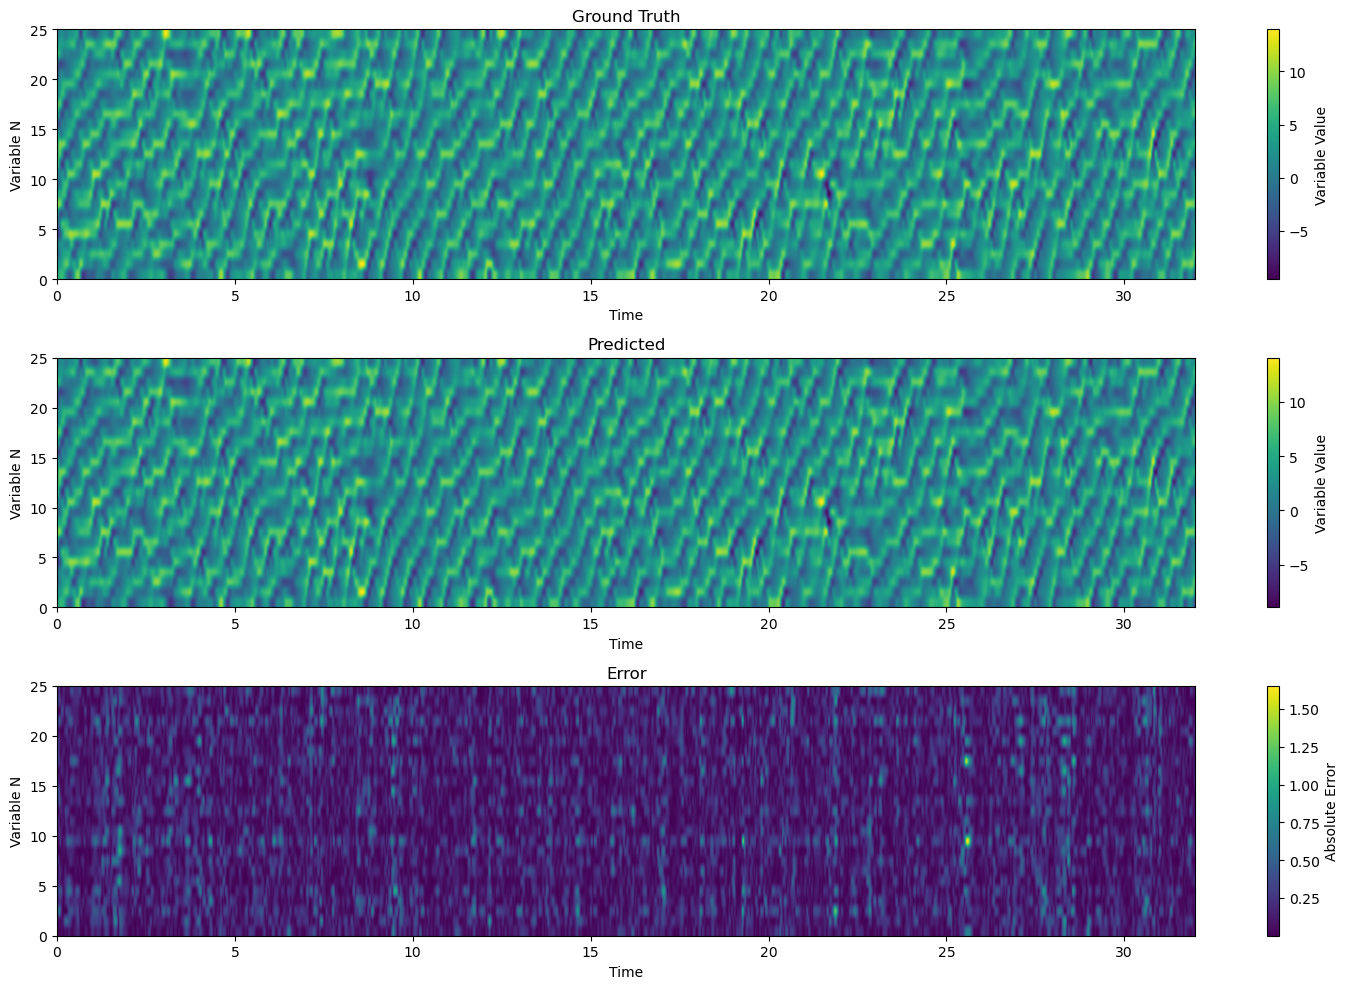

In [4]:
# Plot Ground Truth Atmospheric Graph
plt.figure(figsize=(15, 10))

plt.subplot(3, 1, 1)
plt.imshow(ground_truth_solution[:len(ground_truth_solution)].T, aspect='auto', cmap='viridis', extent=[0, t[-1] * 3.2/10, 0, N])
plt.colorbar(label='Variable Value')
plt.xlabel('Time')
plt.ylabel('Variable N')
plt.title('Ground Truth')

# Plot Predicted Atmospheric Graph
plt.subplot(3, 1, 2)
plt.imshow(predicted_solution[:len(ground_truth_solution)].T, aspect='auto', cmap='viridis', extent=[0, t[-1] * 3.2/10, 0, N])
plt.colorbar(label='Variable Value')
plt.xlabel('Time')
plt.ylabel('Variable N')
plt.title('Predicted')

# Plot Error Atmospheric Graph
plt.subplot(3, 1, 3)
plt.imshow(error[:len(ground_truth_solution)].T, aspect='auto', cmap='viridis', extent=[0, t[-1] * 3.2/10, 0, N])
plt.colorbar(label='Absolute Error')
plt.xlabel('Time')
plt.ylabel('Variable N')
plt.title('Error')

plt.tight_layout()
plt.show()
